In [66]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")

from helpers.synthesis import *
from helpers.visualization import *

from sklearn.metrics import roc_auc_score, roc_curve

dpi = 800


In [70]:
results_dir = "/global/ml4hep/spss/rrmastandrea/synth_SM_AD/NF_results_wide/"

n_sig_inj = [0, 300, 500, 750, 1000, 1200, 1500, 2000, 2500, 3000]#, 3500, 4000, 4500, 5000]# 10000]
n_sig_inj_SR = [0, 226, 376, 565, 753, 904, 1130, 1506, 1883, 2260]

n_seed = 44

num_bkg = 320000
num_sig = 20000


# Load in


In [71]:


process = "None"

keys = ["feta","cathode", "curtains", "salad", "combined", "full_sup"]

n_avg = 4
n_trials_post_avg = int(n_seed / n_avg)

# truth labels
y_test = np.concatenate((torch.zeros((num_bkg, 1)), torch.ones((num_sig,1))))

#x_axis = np.logspace(-8, 0, 400)
x_axis = np.linspace(1e-5, 1, 100)



rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}                
sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
max_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}



In [72]:
for n in n_sig_inj:
    
    print(f"Working on n_sig = {n}...")
    
    # load in the scores data
    all_results_bkg, all_results_sig = load_in_data(n, num_bkg, process,
                                                keys, n_seed, results_dir)
    for k in keys:
            
        for jump in range(0, n_seed, n_avg):
            seeds_to_avg = np.arange(jump, jump + n_avg)

            # average every n_avg scores
            averaged_scores_bkg = np.average([all_results_bkg[k][s] for s in seeds_to_avg], axis = 0)
            averaged_scores_sig = np.average([all_results_sig[k][s] for s in seeds_to_avg], axis = 0)

            # get the roc
            outputs = np.concatenate((averaged_scores_bkg, averaged_scores_sig))
            predicted = np.round(outputs)
            fpr, tpr, _ = roc_curve(y_test, outputs)

            # get sic and rej

            fpr_nonzero_indices = np.where(fpr != 0)
            fpr_nonzero = fpr[fpr_nonzero_indices]

            tpr_nonzero = tpr[fpr_nonzero_indices]

            rejection = 1.0 / fpr_nonzero #np.divide(1.0, fpr, out=np.zeros_like(fpr), where=fpr!=0)
            sic = tpr_nonzero / np.sqrt(fpr_nonzero) #np.divide(tpr, np.sqrt(fpr), out=np.zeros_like(tpr), where=np.sqrt(fpr)!=0)

            eps_bkg = 1.0/((0.4**2)*num_bkg)
            fpr_cutoff_indices = np.where(fpr_nonzero > eps_bkg)
            maxsic = np.nanmax(sic[fpr_cutoff_indices])
            
            # and interpolate
            interp_sic = np.interp(x_axis, tpr_nonzero, sic)
            interp_rej = np.interp(x_axis, tpr_nonzero, rejection)
            rejections_dict[k][n].append(interp_rej)
            sics_dict[k][n].append(interp_sic)
            max_sics_dict[k][n].append(maxsic)
            
print("Done!")


Working on n_sig = 0...
Working on n_sig = 300...
Working on n_sig = 500...
Working on n_sig = 750...
Working on n_sig = 1000...
Working on n_sig = 1200...
Working on n_sig = 1500...
Working on n_sig = 2000...
Working on n_sig = 2500...
Working on n_sig = 3000...
Done!


# Take the avg

In [73]:



med_rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_max_sics_dict = {k:[[],[],[]] for k in keys} # mean, lower_p, upper_p
    
   

for n in n_sig_inj:
    
    for k in keys:
        
        med_rejections_dict[k][n] = get_med_percentile(rejections_dict[k][n])
        med_sics_dict[k][n] = get_med_percentile(sics_dict[k][n])
        
                 
        med_max_sics_dict[k][0].append(np.median(max_sics_dict[k][n]))
        med_max_sics_dict[k][1].append(np.percentile(max_sics_dict[k][n], 16))
        med_max_sics_dict[k][2].append(np.percentile(max_sics_dict[k][n], 84))
                        
        



for k in keys:
    med_max_sics_dict[k][0] = np.array(med_max_sics_dict[k][0])
    med_max_sics_dict[k][1] = np.array(med_max_sics_dict[k][1])
    med_max_sics_dict[k][2] = np.array(med_max_sics_dict[k][2])

In [74]:

colors_dict = {"full_sup":"#56B4E9",
               "salad": "#009E73",
               "feta": "#CC79A7",
               "cathode":"#D55E00",
               "curtains":"#E69F00",
                "combined": "#e41a1c"}\

labels_dict = {"full_sup":"Full. Sup. ",
               "salad": "SALAD",
               "feta": "FETA",
               "cathode":"CATHODE",
               "curtains":"CURTAINs",
                "combined": "Combined"}

hatches_dict = {"full_sup":"Full. Sup. ",
               "salad": "\\",
               "feta": "/",
               "cathode":"-",
               "curtains":"|",
                "combined": "++"}


l = 3
f_1 = 20
f_2 = 30
alpha = 0.4
num_bkg_in_SR = 121339

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


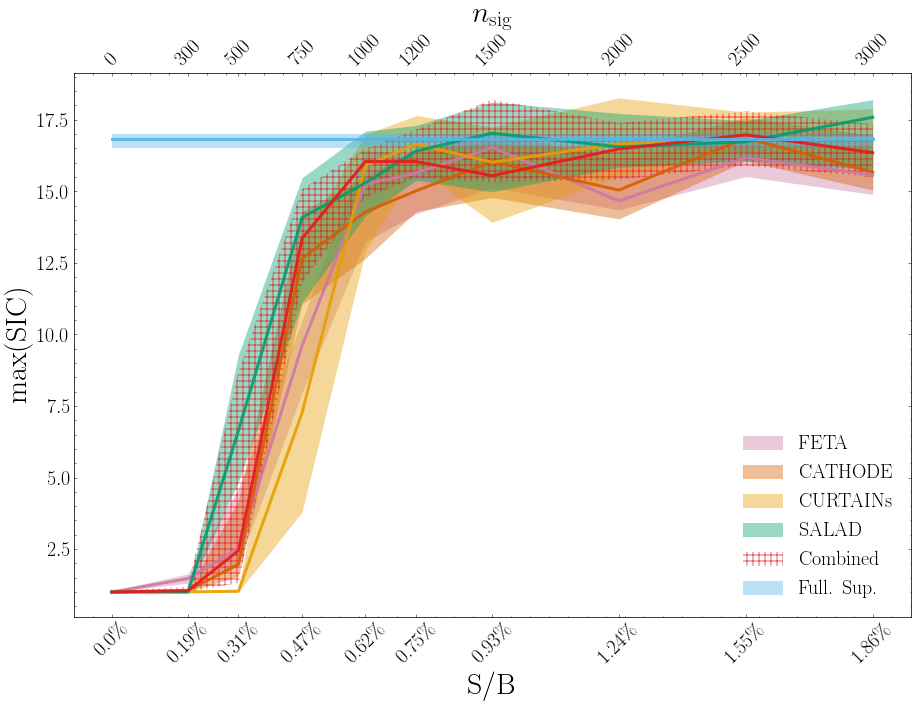

In [75]:


x_vals = [n / num_bkg_in_SR for n in n_sig_inj_SR]


fig = plt.figure(figsize = (15, 10)) 
for k in keys:
    
   
    plt.plot(x_vals, med_max_sics_dict[k][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.5)

    #plt.fill_between(x_vals, mean_max_sics_dict[k][0] -mean_max_sics_dict[k][1],
    #                    mean_max_sics_dict[k][0] + mean_max_sics_dict[k][1],
     #                    alpha = alpha, color = colors_dict[k], linewidth = 0)
        
    if k == "combined":
        plt.fill_between(x_vals, med_max_sics_dict[k][1],
                            med_max_sics_dict[k][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
    else:
        plt.fill_between(x_vals, med_max_sics_dict[k][1],
                            med_max_sics_dict[k][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])
        

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_vals)
ax2.set_xticklabels(n_sig_inj, size=f_1, rotation = 45)
ax2.set_xlabel(r"$n_\mathrm{sig}$", fontsize = f_2, labelpad = 10)


ax1.set_xticks(x_vals)
ax1.set_xticklabels([f"{np.round(100*x, 2)}\%" for x in x_vals], size=f_1, rotation = 45)
ax1.set_xlabel("S/B", fontsize = f_2)

"""
handles, labels = ax1.get_legend_handles_labels()
order = [0, 4, 1, 2, 3]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1, loc = "lower right")
"""
ax1.legend(fontsize = f_1, loc = "lower right")

ax1.set_ylabel("max(SIC)", fontsize = f_2)
ax1.tick_params(axis='both', which='major', labelsize=f_1)
fig.savefig(f"plots/maxsic.pdf", dpi = dpi)

plt.show()





In [76]:
for i, n in enumerate(n_sig_inj_SR):
    
    significance = n / np.sqrt(num_bkg_in_SR)
    
    print(n, med_max_sics_dict["feta"][0][i]*significance)
    

0 0.0
226 0.9537082704520182
376 2.726405435392812
565 15.568177194567225
753 32.95416178425763
904 40.5890161430887
1130 53.62299801302634
1506 63.39244216884269
1883 87.43493989069668
2260 100.98702581055562


# SIC

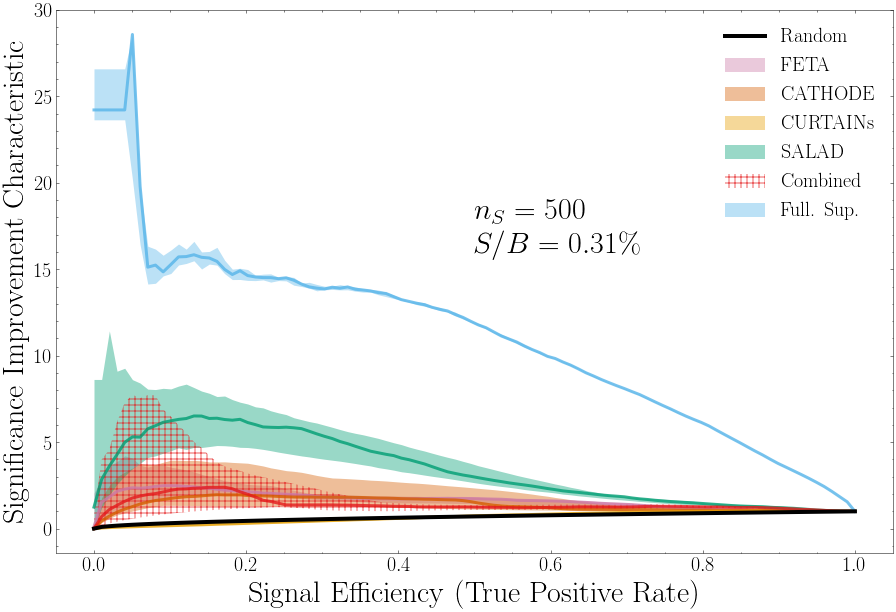

In [81]:
n_to_plot = [500]

for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10))

    for k in keys:
        
        
        plt.plot(x_axis, med_sics_dict[k][n][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

   
        
        if k == "combined":
            plt.fill_between(x_axis, med_sics_dict[k][n][1],
                            med_sics_dict[k][n][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
        else:
                plt.fill_between(x_axis, med_sics_dict[k][n][1],
                            med_sics_dict[k][n][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])
  

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)
    
    ind = n_sig_inj.index(n)
    
    plt.text(0.5, 16, f"$n_S = {n}$\n$S/B = {np.round(100*n_sig_inj_SR[ind]/num_bkg_in_SR, 2)}\%$", fontsize = f_2)

    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)
    """
    
    plt.legend(fontsize = f_1)
    
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)    
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    
    fig.savefig(f"plots/sic_{n}.pdf", dpi = dpi)
    
    plt.show()

# Rejection

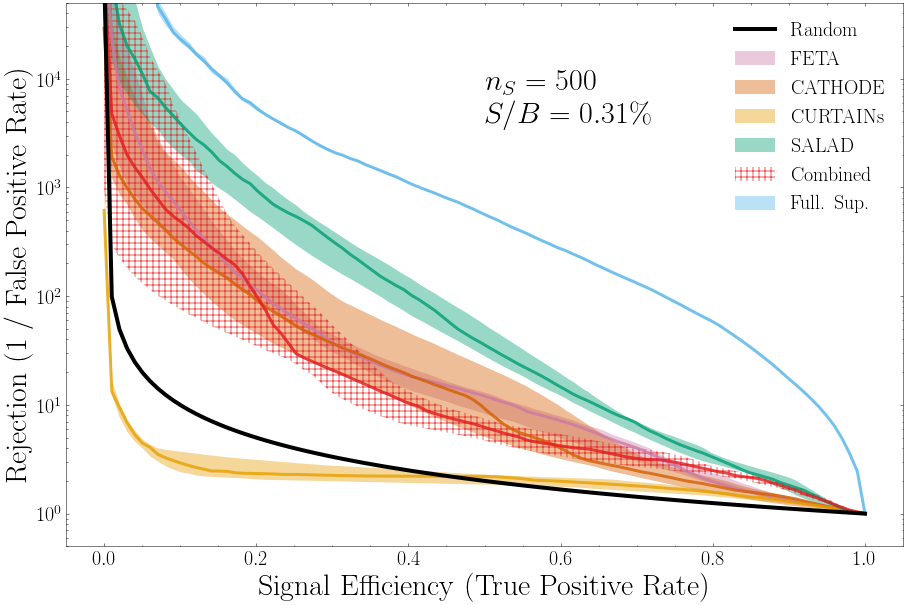

In [82]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys:
        
      
        plt.plot(x_axis, med_rejections_dict[k][n][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

        if k == "combined":
            plt.fill_between(x_axis, med_rejections_dict[k][n][1],
                            med_rejections_dict[k][n][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
        else:
                plt.fill_between(x_axis, med_rejections_dict[k][n][1],
                            med_rejections_dict[k][n][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])

    plt.plot(x_axis, 1.0/x_axis, label = "Random", color = "black", linewidth = l+1)
    
    ind = n_sig_inj.index(n)
    plt.text(0.5, 4000, f"$n_S = {n}$\n$S/B = {np.round(100*n_sig_inj_SR[ind]/num_bkg_in_SR, 2)}\%$", fontsize = f_2)

    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)  
    """   
    plt.legend(fontsize = f_1)  

    
    plt.ylim(5e-1, 5e4)
    plt.yscale("log")
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)  
    plt.ylabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    
    fig.savefig(f"plots/rej_{n}.pdf", dpi = dpi)

    plt.show()

## SIC vs rej

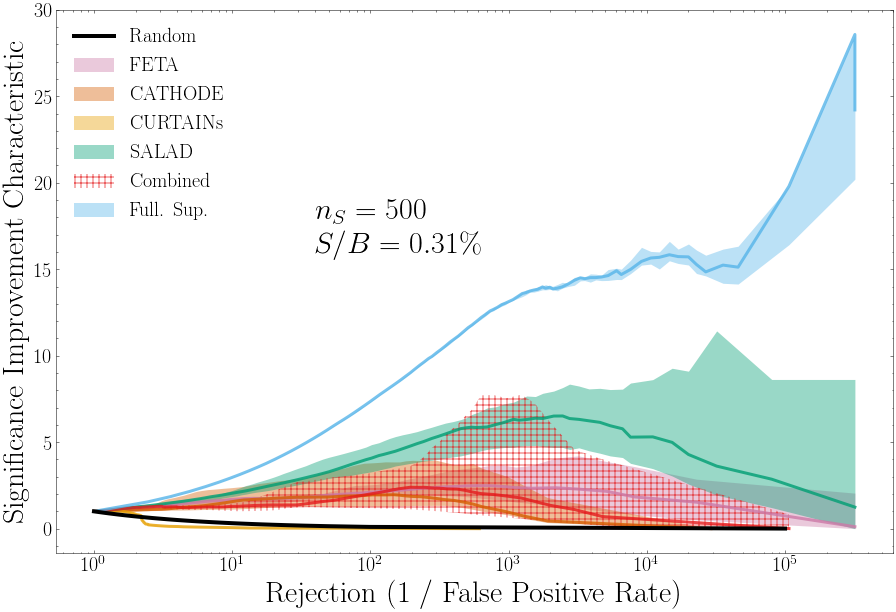

In [83]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys:
        

        plt.plot(med_rejections_dict[k][n][0], med_sics_dict[k][n][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

        if k == "combined":
            plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                            med_sics_dict[k][n][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
        else:
                plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                            med_sics_dict[k][n][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])

    plt.plot(1.0/x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)
    
    
    ind = n_sig_inj.index(n)
    plt.text(40, 16, f"$n_S = {n}$\n$S/B = {np.round(100*n_sig_inj_SR[ind]/num_bkg_in_SR, 2)}\%$", fontsize = f_2)
    
    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)
    """

    plt.legend(fontsize = f_1)
    plt.xscale("log")
    plt.xlabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    fig.savefig(f"plots/sic_vs_rej_{n}.pdf", dpi = dpi)
    


    plt.show()

In [18]:

\
